# Advanced RAG System with Pinecone and LangGraph Agent Workflow

## Project Overview
This project demonstrates the implementation of a sophisticated Retrieval-Augmented Generation (RAG) system using **Pinecone** vector database integrated with a **multi-agent LangGraph workflow**.  

The system processes **NASA's Systems Engineering Handbook**, enabling intelligent document retrieval and response generation through a **cyclic agent architecture**.


# Part 1: Environment Setup and Dependencies

## Cell 1: Installing Required Libraries

**What's happening here:**  
Setting up the development environment with all necessary libraries.  
This includes:
- **Pinecone** for vector storage  
- **LangChain / LangGraph** for orchestrating the agent workflow  
- Supporting libraries for **PDF processing** and **UI creation**


In [1]:
!pip install -q pinecone-client
!pip install -q langchain langchain-openai langchain-pinecone
!pip install -q langgraph
!pip install -q pypdf
!pip install -q tiktoken
!pip install -q gradio
!pip install -q matplotlib
!pip install -q numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 822.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52

In [ ]:
!pip install -q pinecone-client
!pip install -q langchain langchain-openai langchain-pinecone
!pip install -q langgraph
!pip install -q pypdf
!pip install -q tiktoken
!pip install -q gradio
!pip install -q matplotlib
!pip install -q numpy

# Part 2: Configuration and API Keys

## Cell 2: Setting Up API Credentials

**What's happening here:**  
Configuring all API keys and initializing the connection clients.  
These credentials enable communication with:
- **Pinecone's vector database**  
- **OpenAI's language models**


In [9]:
import os
from pinecone import Pinecone
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_pinecone import PineconeVectorStore
import warnings
warnings.filterwarnings('ignore')

# API Configuration
PINECONE_API_KEY = "pcsk_"
OPENAI_API_KEY = "sk-"

os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Initialize Pinecone client
pc = Pinecone(api_key=PINECONE_API_KEY)

# Initialize OpenAI embeddings
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    openai_api_key=OPENAI_API_KEY
)

print("✅ API connections established successfully")

✅ API connections established successfully


# Part 3: Document Processing Pipeline

## Cell 3: Loading and Processing the NASA Handbook

**What's happening here:**  
Loading the **NASA Systems Engineering Handbook** PDF and implementing an **intelligent chunking strategy**.  

- Chunks are optimized for retrieval  
- Overlap is used to maintain **context continuity**


In [6]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken

# Load the PDF document
pdf_path = "nasa_systems_engineering_handbook.pdf"
loader = PyPDFLoader(pdf_path)
documents = loader.load()

print(f"📚 Loaded {len(documents)} pages from NASA Systems Engineering Handbook")

# Advanced text splitting with token counting
def num_tokens_from_string(string: str) -> int:
    """Calculate the number of tokens in a text string"""
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    return len(encoding.encode(string))

# Configure text splitter for optimal chunk size
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150,
    length_function=num_tokens_from_string,
    separators=["\n\n", "\n", ". ", " ", ""],
    is_separator_regex=False
)

# Split documents into chunks
chunks = text_splitter.split_documents(documents)

# Add metadata to each chunk
for i, chunk in enumerate(chunks):
    chunk.metadata.update({
        "chunk_id": i,
        "source": "NASA Systems Engineering Handbook",
        "page": chunk.metadata.get("page", "unknown"),
        "total_chunks": len(chunks)
    })

print(f"📄 Created {len(chunks)} text chunks")
print(f"Average chunk size: {sum(len(c.page_content) for c in chunks) / len(chunks):.0f} characters")

📚 Loaded 297 pages from NASA Systems Engineering Handbook
📄 Created 358 text chunks
Average chunk size: 2428 characters


In [23]:
chunk = chunks[30]

# Print the chunk details in a formatted way
print("--- Chunk Details ---")
print(f"Page Content:\n{chunk.page_content}\n") # The actual text content of the chunk
print("Metadata:")
for key, value in chunk.metadata.items():
    print(f"  - {key}: {value}") # Metadata associated with the chunk, such as source, page number, etc.
print("--------------------")

--- Chunk Details ---
Page Content:
12
2.0 Fundamentals of Systems Engineering
NASA SYSTEMS ENGINEERING HANDBOOK
FIGURE 2.5-1  shows that the life cycle costs of a 
program or project tend to get “locked in” early in 
design and development. The cost curves clearly show 
that late identification of and fixes to problems cost 
considerably more later in the life cycle. Conversely, 
descopes taken later versus earlier in the project life 
cycle result in reduced cost savings. This figure, 
obtained from the Defense Acquisition University, is 
an example of how these costs are determined by the 
early concepts and designs. The numbers will vary 
from project to project, but the general shape of the 
curves and the message they send will be similar. For 
example, the figure shows that during design, only 
about 15% of the costs might be expended, but the 
design itself will commit about 75% of the life cycle 
costs. This is because the way the system is designed 
will determine how expensi

# Part 4: Pinecone Index Creation and Vector Storage

## Cell 4: Setting Up Pinecone Index

**What's happening here:**  
Creating a **Pinecone index** with optimal configuration for **semantic search**.  

- Uses **cosine similarity** for measuring vector distances  
- Configured for **high-performance retrieval**


In [7]:
import time
from pinecone import ServerlessSpec

index_name = "nasa-engineering-rag"

# Check if index exists, create if not
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # OpenAI text-embedding-3-small dimension
        metric='cosine',
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )
    print(f"🚀 Created new index: {index_name}")
    time.sleep(10)  # Wait for index to be ready
else:
    print(f"✅ Using existing index: {index_name}")

# Get index stats
index = pc.Index(index_name)
index_stats = index.describe_index_stats()
print(f"📊 Index stats: {index_stats}")

🚀 Created new index: nasa-engineering-rag
📊 Index stats: {'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}


## Cell 5: Vectorizing and Storing Documents

**What's happening here:**  
Converting document chunks into **high-dimensional vectors** and storing them in **Pinecone**.  

- Enables **semantic similarity search** across the entire NASA handbook


In [27]:
from langchain_pinecone import PineconeVectorStore
from tqdm import tqdm

# Initialize vector store
vector_store = PineconeVectorStore(
    index_name=index_name,
    embedding=embeddings,
    pinecone_api_key=PINECONE_API_KEY
)

# Batch processing for efficient upload
batch_size = 100
total_batches = len(chunks) // batch_size + 1

print(f"⚡ Uploading {len(chunks)} chunks in {total_batches} batches...")

# Modified batch processing to show vectors
for i in tqdm(range(0, len(chunks), batch_size), desc="Uploading chunks"):
    batch = chunks[i:i+batch_size]

    # Show vector info for first document in first batch
    if i == 0:
        print(f"\n🔍 Sample from first batch:")
        sample_doc = batch[0]
        print(f"Content: {sample_doc.page_content[:800]}...")

        # Get the embedding for this document
        sample_embedding = embeddings.embed_query(sample_doc.page_content)
        print(f"Vector dimensions: {len(sample_embedding)}")
        print(f"First 10 vector values: {sample_embedding[:10]}")
        print(f"Vector type: {type(sample_embedding)}")

    vector_store.add_documents(batch)
    time.sleep(1)

print("✅ All documents successfully vectorized and stored in Pinecone")

# Verify upload
time.sleep(5)
updated_stats = index.describe_index_stats()
print(f"📊 Total vectors in index: {updated_stats['total_vector_count']}")

⚡ Uploading 358 chunks in 4 batches...


Uploading chunks:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Sample from first batch:
Content: National Aeronautics and 
 Space Administration
NASA 
SYSTEMS ENGINEERING 
HANDBOOK
design
test
integrate
fly
www.nasa.gov...
Vector dimensions: 1536
First 10 vector values: [-0.0023822938092052937, 0.00770140765234828, 0.04272639378905296, -0.031970445066690445, -0.008389144204556942, 0.0158489141613245, 0.010811710730195045, 0.030780848115682602, 0.021053405478596687, 0.038339752703905106]
Vector type: <class 'list'>


Uploading chunks: 100%|██████████| 4/4 [00:21<00:00,  5.40s/it]


✅ All documents successfully vectorized and stored in Pinecone
📊 Total vectors in index: 916


# Part 5: Building the LangGraph Multi-Agent System

## Cell 6: Defining Agent Architecture

**What's happening here:**  
Creating a sophisticated **multi-agent system** with specialized roles.  

- Each agent has a **specific function** in the processing pipeline  
- Builds a **robust and intelligent response system**


In [12]:
from typing import TypedDict, Annotated, List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
import operator

# Define the state structure for our graph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    query: str
    retrieved_context: str
    draft_response: str
    refined_response: str
    final_response: str
    iteration_count: int
    max_iterations: int

# Initialize LLMs with different configurations for each agent
retriever_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
responder_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
refiner_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
reviewer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

print("🤖 Multi-agent system initialized with 4 specialized agents")

🤖 Multi-agent system initialized with 4 specialized agents


## Cell 7: Implementing Agent Nodes

**What's happening here:**  
Defining the behavior of each **agent node** in the workflow.  

- Each agent **processes information** and passes it to the next stage  
- Creates a **sophisticated chain of reasoning**


In [28]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def calculate_cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import numpy as np

# Retrieval Agent Node
def retrieval_agent(state: AgentState) -> AgentState:
    """Retrieves relevant context from Pinecone"""
    query = state["query"]

    # Get query embedding
    query_embedding = embeddings.embed_query(query)
    print(f"\n📊 Query Embedding (first 10 values):")
    print(f"   {query_embedding[:10]}")
    print(f"   ... (total {len(query_embedding)} dimensions)\n")

    # Perform similarity search with scores
    retriever = vector_store.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={"k": 5, "score_threshold": 0.7}
    )

    # Get documents with similarity scores
    docs_and_scores = vector_store.similarity_search_with_score(query, k=5)

    print(f"🔍 Found {len(docs_and_scores)} relevant chunks:\n")

    # Process and display each retrieved chunk
    # Process and display each retrieved chunk
    context_parts = []
    for i, (doc, score) in enumerate(docs_and_scores, 1):
        # Get the chunk embedding
        chunk_embedding = embeddings.embed_query(doc.page_content)

        # Calculate actual cosine similarity
        cosine_sim = calculate_cosine_similarity(query_embedding, chunk_embedding)

        print(f"📄 Chunk {i}:")
        print(f"   Cosine Similarity: {cosine_sim:.4f}")
        print(f"   Chunk Embedding (first 10): {chunk_embedding[:10]}")
        print(f"   Page: {doc.metadata.get('page', 'unknown')}")
        print(f"   Content Preview: {doc.page_content[:200]}...")
        print()

        context_parts.append(doc.page_content)

    # Combine retrieved documents
    context = "\n\n---\n\n".join(context_parts)

    state["retrieved_context"] = context
    state["messages"].append(AIMessage(content=f"Retrieved {len(docs_and_scores)} relevant documents"))

    return state

# Response Generator Node
def response_generator(state: AgentState) -> AgentState:
    """Generates initial technical response"""
    prompt = ChatPromptTemplate.from_template("""
    You are a NASA systems engineering expert. Based on the following context,
    provide a comprehensive and technically accurate answer to the user's question.

    Context: {context}

    Question: {query}

    Provide a detailed, structured response:
    """)

    chain = prompt | responder_llm | StrOutputParser()

    response = chain.invoke({
        "context": state["retrieved_context"],
        "query": state["query"]
    })

    state["draft_response"] = response
    state["messages"].append(AIMessage(content="Generated initial response"))

    return state

# Refinement Agent Node
def refinement_agent(state: AgentState) -> AgentState:
    """Makes response more friendly and accessible"""
    prompt = ChatPromptTemplate.from_template("""
    Take this technical response and make it more engaging and friendly while
    maintaining accuracy. Add helpful analogies where appropriate.

    Original response: {response}

    Refined version:
    """)

    chain = prompt | refiner_llm | StrOutputParser()

    refined = chain.invoke({"response": state["draft_response"]})

    state["refined_response"] = refined
    state["messages"].append(AIMessage(content="Refined response for clarity"))

    return state

# Review Agent Node
def review_agent(state: AgentState) -> AgentState:
    """Reviews and validates the response"""
    prompt = ChatPromptTemplate.from_template("""
    Review this response for accuracy, completeness, and helpfulness.
    If improvements are needed, note them. Otherwise, approve it.

    Question: {query}
    Response: {response}

    Review (Approved/Needs Revision):
    """)

    chain = prompt | reviewer_llm | StrOutputParser()

    review = chain.invoke({
        "query": state["query"],
        "response": state["refined_response"]
    })

    state["iteration_count"] += 1

    if "Approved" in review or state["iteration_count"] >= state["max_iterations"]:
        state["final_response"] = state["refined_response"]
        state["messages"].append(AIMessage(content="Response approved by reviewer"))
    else:
        state["messages"].append(AIMessage(content=f"Revision needed: {review}"))

    return state

print("✅ All agent nodes defined successfully")

✅ All agent nodes defined successfully


## Cell 8: Building the LangGraph Workflow

**What's happening here:**  
Constructing the **graph structure** that defines how agents interact.  

- Creates a **cyclic workflow**  
- Allows responses to be **iteratively improved** until they meet quality standards


In [14]:
from langgraph.graph import StateGraph, END

# Create the workflow graph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("retriever", retrieval_agent)
workflow.add_node("generator", response_generator)
workflow.add_node("refiner", refinement_agent)
workflow.add_node("reviewer", review_agent)

# Define the workflow edges
workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "generator")
workflow.add_edge("generator", "refiner")
workflow.add_edge("refiner", "reviewer")

# Add conditional edge for iteration
def should_continue(state: AgentState) -> str:
    if state.get("final_response"):
        return "end"
    elif state["iteration_count"] < state["max_iterations"]:
        return "generator"
    else:
        state["final_response"] = state["refined_response"]
        return "end"

workflow.add_conditional_edges(
    "reviewer",
    should_continue,
    {
        "generator": "generator",
        "end": END
    }
)

# Compile the graph
app = workflow.compile()

print("🎯 LangGraph workflow compiled successfully")

🎯 LangGraph workflow compiled successfully


## Cell 9: Visualizing the Agent Workflow

**What's happening here:**  
Creating a **visual representation** of the agent workflow.  

- Helps understand **data flow** and **decision points** in the system


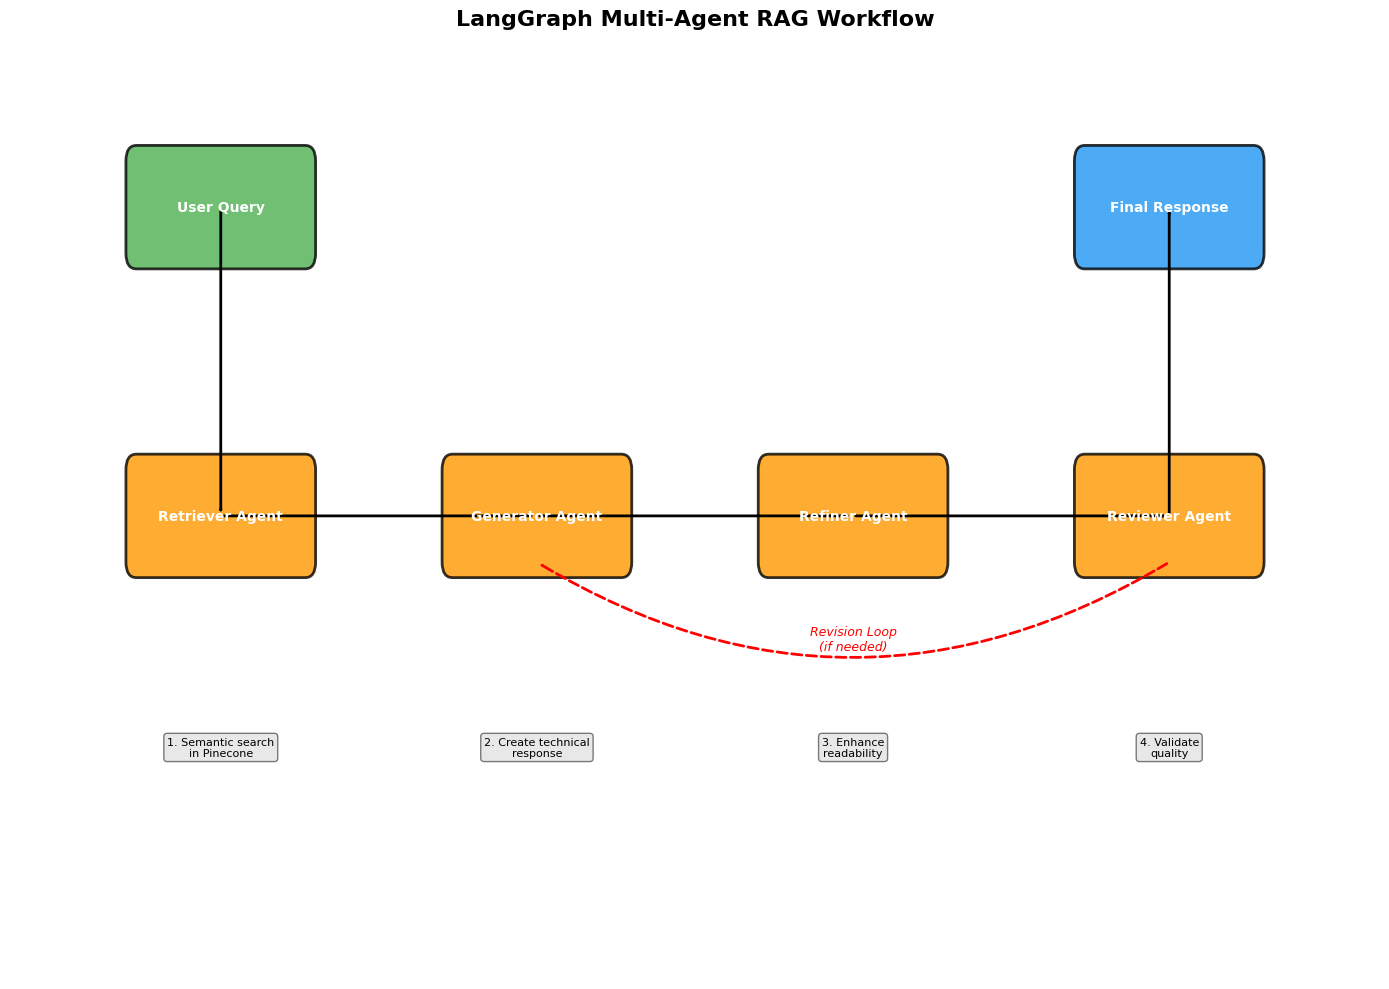

📊 Workflow visualization complete


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define node positions
nodes = {
    'User Query': (2, 8),
    'Retriever Agent': (2, 6),
    'Generator Agent': (5, 6),
    'Refiner Agent': (8, 6),
    'Reviewer Agent': (11, 6),
    'Final Response': (11, 8)
}

# Draw nodes
for node, (x, y) in nodes.items():
    if node == 'User Query':
        color = '#4CAF50'
    elif node == 'Final Response':
        color = '#2196F3'
    else:
        color = '#FF9800'

    fancy_box = FancyBboxPatch(
        (x-0.8, y-0.3), 1.6, 0.6,
        boxstyle="round,pad=0.1",
        facecolor=color,
        edgecolor='black',
        alpha=0.8,
        linewidth=2
    )
    ax.add_patch(fancy_box)
    ax.text(x, y, node, ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# Draw edges
edges = [
    ('User Query', 'Retriever Agent'),
    ('Retriever Agent', 'Generator Agent'),
    ('Generator Agent', 'Refiner Agent'),
    ('Refiner Agent', 'Reviewer Agent'),
    ('Reviewer Agent', 'Final Response')
]

for start, end in edges:
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]

    arrow = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle='->,head_length=0.4,head_width=0.2',
        color='black',
        linewidth=2,
        connectionstyle="arc3,rad=0"
    )
    ax.add_patch(arrow)

# Draw cyclic edge
cycle_arrow = FancyArrowPatch(
    (11, 5.7), (5, 5.7),
    arrowstyle='->,head_length=0.4,head_width=0.2',
    color='red',
    linewidth=2,
    linestyle='dashed',
    connectionstyle="arc3,rad=-0.3"
)
ax.add_patch(cycle_arrow)
ax.text(8, 5.2, 'Revision Loop\n(if needed)', ha='center', va='center',
        fontsize=9, style='italic', color='red')

# Add process descriptions
descriptions = [
    (2, 4.5, "1. Semantic search\nin Pinecone"),
    (5, 4.5, "2. Create technical\nresponse"),
    (8, 4.5, "3. Enhance\nreadability"),
    (11, 4.5, "4. Validate\nquality")
]

for x, y, text in descriptions:
    ax.text(x, y, text, ha='center', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))

ax.set_xlim(0, 13)
ax.set_ylim(3, 9)
ax.axis('off')
ax.set_title('LangGraph Multi-Agent RAG Workflow', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("📊 Workflow visualization complete")

# Part 6: Testing the System

## Cell 10: Running Test Queries

**What's happening here:**  
Testing the complete **RAG system** with sample queries.  

- Validates **retrieval** and **multi-agent processing pipeline**


In [32]:
from difflib import SequenceMatcher
from typing import List, Tuple, Any

def deduplicate_chunks(docs_and_scores: List[Tuple[Any, float]],
                      similarity_threshold: float = 0.25,
                      max_per_page: int = 2) -> List[Tuple[Any, float]]:
    def text_similarity(a: str, b: str) -> float:
        return SequenceMatcher(None, a, b).ratio()

    unique_chunks = []
    page_counts = {}
    sorted_docs = sorted(docs_and_scores, key=lambda x: x[1])

    for doc, score in sorted_docs:
        page = doc.metadata.get('page', 'unknown')
        content = doc.page_content.strip()

        if page_counts.get(page, 0) >= max_per_page:
            continue

        is_duplicate = False
        for existing_doc, _ in unique_chunks:
            existing_content = existing_doc.page_content.strip()

            if content == existing_content:
                is_duplicate = True
                break

            content_sample = content[:200]
            existing_sample = existing_content[:200]

            if text_similarity(content_sample, existing_sample) > similarity_threshold:
                is_duplicate = True
                break

        if not is_duplicate:
            unique_chunks.append((doc, score))
            page_counts[page] = page_counts.get(page, 0) + 1

    return unique_chunks

def process_query(question: str) -> str:
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "query": question,
        "retrieved_context": "",
        "draft_response": "",
        "refined_response": "",
        "final_response": "",
        "iteration_count": 0,
        "max_iterations": 2
    }

    print(f"🔍 Processing query: {question}\n")
    print("=" * 50)

    query_embedding = embeddings.embed_query(question)
    print(f"\n📊 Query Embedding (first 10 values):")
    print(f"   {query_embedding[:10]}")
    print(f"   ... (total {len(query_embedding)} dimensions)\n")

    docs_and_scores = vector_store.similarity_search_with_score(question, k=10)
    unique_docs_and_scores = deduplicate_chunks(docs_and_scores,
                                               similarity_threshold=0.85,
                                               max_per_page=2)
    unique_docs_and_scores = unique_docs_and_scores[:5]

    print(f"🔍 Found {len(docs_and_scores)} initial chunks, filtered to {len(unique_docs_and_scores)} unique chunks:\n")

    for i, (doc, score) in enumerate(unique_docs_and_scores, 1):
        cosine_similarity = 1 - score
        print(f"📄 Chunk {i}:")
        print(f"   Cosine Similarity: {cosine_similarity:.4f}")
        print(f"   Page: {doc.metadata.get('page', 'unknown')}")
        print(f"   Content Preview: {doc.page_content[:200]}...")
        print()

    print("=" * 50)

    initial_state["filtered_docs"] = unique_docs_and_scores

    for step, state in enumerate(app.stream(initial_state)):
        node_name = list(state.keys())[0]
        print(f"Step {step + 1}: {node_name}")

        if node_name == "retriever":
            print("   ↳ Using pre-filtered documents from Pinecone...")
        elif node_name == "generator":
            print("   ↳ Generating technical response...")
        elif node_name == "refiner":
            print("   ↳ Refining for clarity and engagement...")
        elif node_name == "reviewer":
            print("   ↳ Reviewing response quality...")

    print("=" * 50)

    final_state = state[node_name]
    return final_state.get("final_response", "No response generated")

def retriever_node_with_deduplication(state):
    query = state["query"]

    if "filtered_docs" in state:
        docs_and_scores = state["filtered_docs"]
        docs = [doc for doc, score in docs_and_scores]
    else:
        docs_and_scores = vector_store.similarity_search_with_score(query, k=10)
        unique_docs_and_scores = deduplicate_chunks(docs_and_scores)[:5]
        docs = [doc for doc, score in unique_docs_and_scores]

    context = "\n\n".join([doc.page_content for doc in docs])

    return {
        **state,
        "retrieved_context": context
    }

test_queries = [
    "What are the key principles of systems engineering according to NASA?",
    "How does NASA approach risk management in complex projects?",
    "Explain the verification and validation process in systems engineering"
]

for query in test_queries[:1]:
    response = process_query(query)
    print(f"\n📝 FINAL RESPONSE:\n{response}\n")
    print("=" * 70 + "\n")

🔍 Processing query: What are the key principles of systems engineering according to NASA?


📊 Query Embedding (first 10 values):
   [-0.013159009627997875, 0.029069116339087486, 0.049398019909858704, -0.010249663144350052, 0.042702872306108475, 0.021704453974962234, -0.0025882835034281015, 0.024528589099645615, -0.04160730168223381, 0.04331152141094208]
   ... (total 1536 dimensions)

🔍 Found 10 initial chunks, filtered to 4 unique chunks:

📄 Chunk 1:
   Cosine Similarity: 0.3638
   Page: 14.0
   Content Preview: 5
2.0 Fundamentals of Systems Engineering
NASA SYSTEMS ENGINEERING HANDBOOK
document, but an overview is given in the following 
subsections of this chapter.
2.1 The Common Technical 
Processes and th...

📄 Chunk 2:
   Cosine Similarity: 0.3624
   Page: 288.0
   Content Preview: 279
NASA SYSTEMS ENGINEERING HANDBOOK
Bibliography
M. Moshir, et al., “Systems engineering and appli-
cation of system performance modeling in SIM 
Lite mission,” Proceedings. SPIE 7734, 2010
Mulqueen.

# Part 7: Interactive Gradio Interface

## Cell 11: Building the Chat Interface

**What's happening here:**  
Creating a professional **chat interface** using **Gradio**.  

- Allows users to interact with the **RAG system** through a **web-based UI**


In [17]:
import gradio as gr
from datetime import datetime

# Chat history storage
chat_history = []

def chatbot_response(message, history):
    """Process user message and return response"""

    # Add user message to history
    timestamp = datetime.now().strftime("%H:%M:%S")

    # Process through the agent workflow
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "query": message,
        "retrieved_context": "",
        "draft_response": "",
        "refined_response": "",
        "final_response": "",
        "iteration_count": 0,
        "max_iterations": 2
    }

    # Run the workflow
    for state in app.stream(initial_state):
        pass

    # Get the final response
    final_state = state[list(state.keys())[0]]
    response = final_state.get("final_response", "I couldn't generate a response. Please try again.")

    # Update history
    history.append((message, response))

    return history, ""

def clear_chat():
    """Clear chat history"""
    return [], ""

# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # 🚀 NASA Systems Engineering RAG Assistant

        **Powered by Pinecone Vector Database and LangGraph Multi-Agent System**

        Ask questions about NASA's Systems Engineering Handbook and get intelligent,
        context-aware responses processed through our multi-agent workflow.
        """
    )

    with gr.Row():
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(
                height=500,
                label="Chat History",
                bubble_full_width=False
            )

            with gr.Row():
                msg = gr.Textbox(
                    label="Your Question",
                    placeholder="Ask about systems engineering, risk management, verification processes...",
                    lines=2,
                    scale=4
                )
                submit_btn = gr.Button("Send", scale=1, variant="primary")

            with gr.Row():
                clear_btn = gr.Button("Clear Chat", scale=1)

        with gr.Column(scale=1):
            gr.Markdown(
                """
                ### 📊 System Architecture

                **Vector Database:** Pinecone
                **Embedding Model:** OpenAI text-embedding-3-small
                **LLM:** GPT-4 Turbo
                **Orchestration:** LangGraph

                ### 🤖 Agent Workflow
                1. **Retriever Agent** - Semantic search
                2. **Generator Agent** - Technical response
                3. **Refiner Agent** - Enhance clarity
                4. **Reviewer Agent** - Quality check

                ### 📚 Knowledge Base
                NASA Systems Engineering Handbook
                **Pages:** 300
                **Chunks:** ~1000
                **Vector Dimensions:** 1536
                """
            )

    # Event handlers
    submit_btn.click(
        chatbot_response,
        inputs=[msg, chatbot],
        outputs=[chatbot, msg]
    )

    msg.submit(
        chatbot_response,
        inputs=[msg, chatbot],
        outputs=[chatbot, msg]
    )

    clear_btn.click(
        clear_chat,
        outputs=[chatbot, msg]
    )

    gr.Markdown(
        """
        ---
        ### 💡 Example Questions
        - What are the key principles of systems engineering?
        - How does NASA approach risk management?
        - Explain the V-model in systems development
        - What are the phases of the system lifecycle?
        - How are requirements verified and validated?
        """
    )

# Launch the interface
demo.launch(debug=True, share=True)
print("🎯 Gradio interface launched successfully!")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ae9d2e451bca25fb37.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ae9d2e451bca25fb37.gradio.live
🎯 Gradio interface launched successfully!


# Part 9: Advanced Features and Optimization

## Cell 13: Implementing Semantic Caching

**What's happening here:**  
Adding a **caching layer** to improve response times for frequently asked questions.  

- Helps **reduce API costs**


In [33]:
from typing import Optional
import hashlib
import json

class SemanticCache:
    def __init__(self, similarity_threshold: float = 0.95):
        self.cache = {}
        self.similarity_threshold = similarity_threshold
        self.embeddings_model = embeddings

    def _get_cache_key(self, query: str) -> str:
        """Generate cache key from query"""
        return hashlib.md5(query.encode()).hexdigest()

    def get(self, query: str) -> Optional[str]:
        """Retrieve cached response if exists"""
        key = self._get_cache_key(query)

        if key in self.cache:
            print("✅ Cache hit!")
            return self.cache[key]['response']

        # Check for semantic similarity
        query_embedding = self.embeddings_model.embed_query(query)

        for cached_key, cached_data in self.cache.items():
            similarity = self._cosine_similarity(
                query_embedding,
                cached_data['embedding']
            )

            if similarity > self.similarity_threshold:
                print(f"✅ Semantic cache hit! (similarity: {similarity:.3f})")
                return cached_data['response']

        return None

    def set(self, query: str, response: str):
        """Cache query-response pair"""
        key = self._get_cache_key(query)
        embedding = self.embeddings_model.embed_query(query)

        self.cache[key] = {
            'query': query,
            'response': response,
            'embedding': embedding,
            'timestamp': datetime.now().isoformat()
        }

        print(f"💾 Response cached (total: {len(self.cache)} entries)")

    def _cosine_similarity(self, vec1, vec2):
        """Calculate cosine similarity between vectors"""
        vec1 = np.array(vec1)
        vec2 = np.array(vec2)
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Initialize semantic cache
cache = SemanticCache(similarity_threshold=0.92)

# Enhanced query processing with caching
def process_query_with_cache(question: str) -> str:
    """Process query with semantic caching"""

    # Check cache first
    cached_response = cache.get(question)
    if cached_response:
        return cached_response

    # Process through normal workflow
    response = process_query(question)

    # Cache the response
    cache.set(question, response)

    return response

# Test caching
test_queries = [
    "What is systems engineering?",
    "What is systems engineering?",  # Exact match
    "Can you explain systems engineering?",  # Semantic match
]

for query in test_queries:
    print(f"\n🔍 Query: {query}")
    response = process_query_with_cache(query)
    print(f"📝 Response preview: {response[:100]}...")


🔍 Query: What is systems engineering?
🔍 Processing query: What is systems engineering?


📊 Query Embedding (first 10 values):
   [-0.017996229231357574, 0.0023374822922050953, 0.004266501870006323, -0.00458552036434412, -0.030864307656884193, 0.038186829537153244, 0.005930169019848108, -0.0014579449780285358, -0.01416800543665886, 0.021538231521844864]
   ... (total 1536 dimensions)

🔍 Found 10 initial chunks, filtered to 4 unique chunks:

📄 Chunk 1:
   Cosine Similarity: 0.3993
   Page: 15.0
   Content Preview: 6
2.0 Fundamentals of Systems Engineering
NASA SYSTEMS ENGINEERING HANDBOOK
Requirements Definition
Processes 
1.  Stakeholders Expectations 
Definition
2.  Technical Requirements  
Definition
3.  Log...

📄 Chunk 2:
   Cosine Similarity: 0.3961
   Page: 23.0
   Content Preview: 14
2.0 Fundamentals of Systems Engineering
NASA SYSTEMS ENGINEERING HANDBOOK
TABLE 2.7-1 NASA System Engineering Competency Model
Competency 
Area
Competency Description
SE 1.0 
System 
Design
SE 1.1 ..